## Домашка 2
<h4><em>«Одно Кольцо, чтоб править всеми,<br>
Одно Кольцо, чтоб всех найти,<br>
Одно Кольцо, чтоб собрать всех в тени<br>
И заковать их всех во Тьме»</em><br>
— <em>Властелин колец</em>
</h4>

Эта домашка про приоритизацию метрик. За неё можно получить максимум 12 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Скачайте этот ноутбук.
2. Решите задания (локально или в Google Colab). 
3. Опубликуйте решенный ноутбук в свой GitHub репозиторий (проверьте, чтобы он был публичным).
4. Приложите ссылку на решение в Яндекс-Форму для сдачи ДЗ (будет доступна на LMS Karpov Courses и в Телеграм-канале курса).

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.

Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_2_data.zip)

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from datetime import datetime
import seaborn as sns 
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

### Функции для визуализации из семинара

In [5]:
def get_line_plot(df, x, y, title, annotate=False):
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    if len(y) == 2:
        ax1.plot(df[x], df[y[0]], label=y[0], color='blue')
        ax1.set_ylabel(y[0])

        plt.xticks(rotation=45)

        if annotate:
            for i, val in enumerate(df[y[0]]):
                ax1.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        ax2 = ax1.twinx()
        ax2.plot(df[x], df[y[1]], label=y[1], color='green')
        ax2.set_ylabel(f'{y[1]}')
        ax2.tick_params(axis='y')

        if annotate:
            for i, val in enumerate(df[y[1]]):
                ax2.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2,
                   loc='center left', bbox_to_anchor=(1.05, 0.8))

        ax1.grid(True, which='both')
        fig.suptitle(title)
        fig.tight_layout()
        
        return plt.show()

    else:
        for col in y:
            plt.plot(df[x], df[col], label=col, color='blue')

            if annotate:
                for i, val in enumerate(df[col]):
                    plt.text(df[x].iloc[i], val, f'{val:.2f}', fontsize=9)

        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Metric Value')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()

    return plt.show()

In [7]:
def get_several_lines_plot(df, x, y_list, title):
    plt.figure(figsize=(12,6))
    colors = ['green', 'blue', 'orange', 'pink', 'violet']
    
    for i, col in enumerate(y_list):
        if x == 'date':
            x_axis = df[x]
        else:
            x_axis = df[x].astype(str)

        y_axis = df[col]
        plt.plot(x_axis, y_axis, label=col, color=colors[i])

        for xi, yi in zip(x_axis, y_axis):
            plt.text(xi, yi, f'{yi:.2f}', fontsize=9, ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Metric Value')
    
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
def get_heatmap(df, x, y_list, y_label, title):
    data = df.set_index(x)[y_list].T
    
    plt.figure(figsize=(14, len(y_list)*0.5 + 2))
    sns.heatmap(data, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
def get_category_plot(df, x_col, metric, cal_column, title):
    
    plt.figure(figsize=(12,6))
    
    for cat in df[cal_column].unique():
        temp = df[df[cal_column] == cat]
        plt.plot(temp[x_col], temp[metric], label=cat)
        
        for x, y in zip(temp[x_col], temp[metric]):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    
    plt.tight_layout()
    plt.show()

In [13]:
def get_stacked_area_plot(df, x_col, share_col, cat_col, title, annotate=True):
    df_c = df[[x_col, cat_col, share_col]].copy()
    
    pivot = (df_c.pivot(index=x_col, columns=cat_col, values=share_col)
                .fillna(0.0)
                .sort_index())
    
    pivot.index = pd.to_datetime(pivot.index)
    
    colors = sns.color_palette('Set2', n_colors=len(pivot.columns))
    ax = pivot.plot(kind='area', stacked=True, figsize=(12, 6), color=colors)

    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Share')
    plt.grid(True, axis='y', linestyle=':')

    if annotate:
        cum = pivot.cumsum(axis=1)
        for t in pivot.index:
            for col, color in zip(pivot.columns, colors):
                share = float(pivot.at[t, col])
                if share <= 0:
                    continue
                y_center = float(cum.at[t, col] - share / 2.0)
                ax.annotate(f'{share:.2%}',
                            xy=(t, y_center),
                            xytext=(0, 0), textcoords='offset points',
                            ha='center', va='center',
                            fontsize=7)

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.9))
    plt.tight_layout()
    plt.show()

### Warm up

#### 1. Game dev — 2 балла
У вас есть данные о событиях в мобильной игре. Рассчитайте и визуализируйте:
- User Stickiness — отношение DAU к MAU (MAU рассчитывайте скользящим окном 30 дней для каждой даты только для полного окна)
- ARPDAU
- Paying Share — доля платящих пользователей
- Sessions per User — среднее число сессий на пользователя
- Daily Play Time — среднее время, проводимое пользователем в игре в день (рассчитываем как общее время в приложении)
- Avg Attempts per Session — среднее число попыток на сессию

*Смотрим на подневную динамику

In [15]:
df_game = pd.read_csv('hw_2_data/data/hw_2_gamedev.csv', index_col=0)
df_game.head()

,session_id,user,date,revenue,attempts,session_length_sec
0,24590322,k0xevcHJ,2022-11-02,NaN,2.0,263
1,24590323,fMaLiagr,2022-11-02,NaN,10.0,953
2,24590324,0EXv0Q2V,2022-11-02,NaN,6.0,630
3,24590325,nY32SwuK,2022-11-02,NaN,9.0,1262
4,24590326,3KZkImTN,2022-11-02,NaN,16.0,2871


In [25]:
df_game[~df_game.revenue.isna()]

,session_id,user,date,revenue,attempts,session_length_sec
416,24590738,V1JGUgoe,2022-11-02,15.99,14.0,1540
607,24590929,l6zTe5UU,2022-11-02,2.99,60.0,7679
1537,24591859,Bz25nDU8,2022-11-02,6.99,44.0,5212
5218,24595540,HGTYn6xK,2022-11-02,9.98,25.0,2855
5803,24596125,N8jtcWTy,2022-11-02,2.99,99.0,10332
...,...,...,...,...,...,...
3151227,27741549,Ya6XL3hi,2023-01-05,4.96,84.0,7606
3151358,27741680,Nnt4zJT9,2023-01-05,1.98,37.0,3576
3151359,27741681,Nnt4zJT9,2023-01-05,0.99,37.0,2864
3151362,27741684,VMNpArUQ,2023-01-05,7.98,64.0,7121


Описание данных (уникальный ключ session_id)

- session_id — уникальный идентификатор сессии
- user — уникальный идентификатор юзера
- date — дата 
- revenue — суммарная выручка на сессию
- attempts — число попыток на сессию
- session_length_sec — длина сессии в секундах

In [13]:
df_game.describe()

,session_id,revenue,attempts,session_length_sec
count,3.151378e+06,99866.000000,2.960048e+06,3.151378e+06
mean,2.616601e+07,6.357798,2.753213e+01,3.109896e+03
std,9.097246e+05,82.967460,4.524357e+01,5.560150e+03
min,2.459032e+07,0.990000,1.000000e+00,2.000000e+00
25%,2.537817e+07,1.980000,6.000000e+00,4.990000e+02
50%,2.616601e+07,2.990000,1.500000e+01,1.505000e+03
75%,2.695385e+07,6.990000,3.400000e+01,3.828000e+03
max,2.774170e+07,9701.213976,1.512913e+03,2.952370e+05


In [19]:
# your code is here
df_game.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3151378 entries, 0 to 3151377
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   session_id          int64  
 1   user                object 
 2   date                object 
 3   revenue             float64
 4   attempts            float64
 5   session_length_sec  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 168.3+ MB


User Stickiness — отношение DAU к MAU (MAU рассчитывайте скользящим окном 30 дней для каждой даты только для полного окна)
ARPDAU


In [33]:
import pandas as pd


df_game['date'] = pd.to_datetime(df_game['date'])

# DAU = количество уникальных пользователей по датам
dau = df_game.groupby('date')['user'].nunique().rename('DAU')

# MAU = количество уникальных пользователей за 30 дней
# rolling с min_periods=30 — берём только полные окна
mau = (
    df_game
    .set_index('date')
    .groupby('user')
    .rolling('30D')
    .count()
    .reset_index()
)


mau = (
    df_game.groupby('date')
    .apply(lambda x: df_game.loc[
        (df_game['date'] > x.name - pd.Timedelta(days=30)) & 
        (df_game['date'] <= x.name),
        'user'
    ].nunique())
    .rename('MAU')
)

# объединяем
stickiness = pd.concat([dau, mau], axis=1).dropna()

# считаем метрику
stickiness['Stickiness'] = stickiness['DAU'] / stickiness['MAU']

print(stickiness.head(10))


              DAU     MAU  Stickiness
date                                 
2022-11-02  18710   18710    1.000000
2022-11-03  48669   58530    0.831522
2022-11-04  60913   95022    0.641041
2022-11-05  77372  137113    0.564294
2022-11-06  90436  179274    0.504457
2022-11-07  55711  179274    0.310759
2022-11-08  47593  179274    0.265476
2022-11-09  42971  179274    0.239695
2022-11-10  38999  179274    0.217539
2022-11-11  37635  179274    0.209930


In [36]:
stickiness =stickiness.reset_index()
stickiness.head(1)

,date,DAU,MAU,Stickiness
0,2022-11-02,18710,18710,1.0


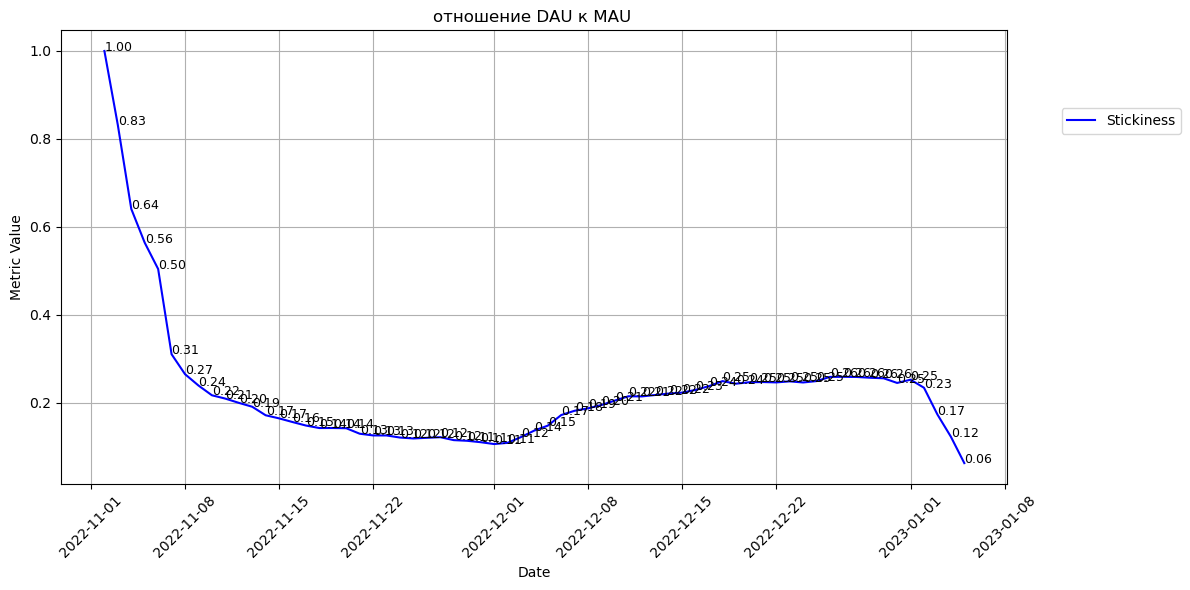

In [38]:
get_line_plot(stickiness, 'date', ['Stickiness'], 'отношение DAU к MAU ', annotate=True)

пу пу пу, тревожно

In [21]:
df_game.head(2)

,session_id,user,date,revenue,attempts,session_length_sec
0,24590322,k0xevcHJ,2022-11-02,NaN,2.0,263
1,24590323,fMaLiagr,2022-11-02,NaN,10.0,953


Paying Share — доля платящих пользователей
df_game

In [33]:
df_all_users = df_game.groupby(['date'], as_index=False) \
    .agg(all_users=('user', 'nunique'))

In [39]:
df_pay_users = df_game[~df_game.revenue.isna()].groupby(['date'], as_index=False) \
    .agg(pay_users=('user', 'nunique'))

In [43]:
df_users = pd.merge(df_all_users,df_pay_users, on = 'date' )

In [47]:
df_users['paying_share'] = df_users['pay_users'] /df_users['all_users'] 

In [53]:
df_users['paying_share_proc'] = df_users['pay_users'] /df_users['all_users']* 100

In [55]:
df_users

,date,all_users,pay_users,paying_share,paying_share_proc
0,2022-11-02,18710,21,0.001122,0.112239
1,2022-11-03,48669,139,0.002856,0.285603
2,2022-11-04,60913,280,0.004597,0.459672
3,2022-11-05,77372,431,0.005570,0.557049
4,2022-11-06,90436,626,0.006922,0.692202
...,...,...,...,...,...
60,2023-01-01,13868,499,0.035982,3.598212
61,2023-01-02,12667,472,0.037262,3.726218
62,2023-01-03,9204,324,0.035202,3.520209
63,2023-01-04,6434,218,0.033882,3.388250


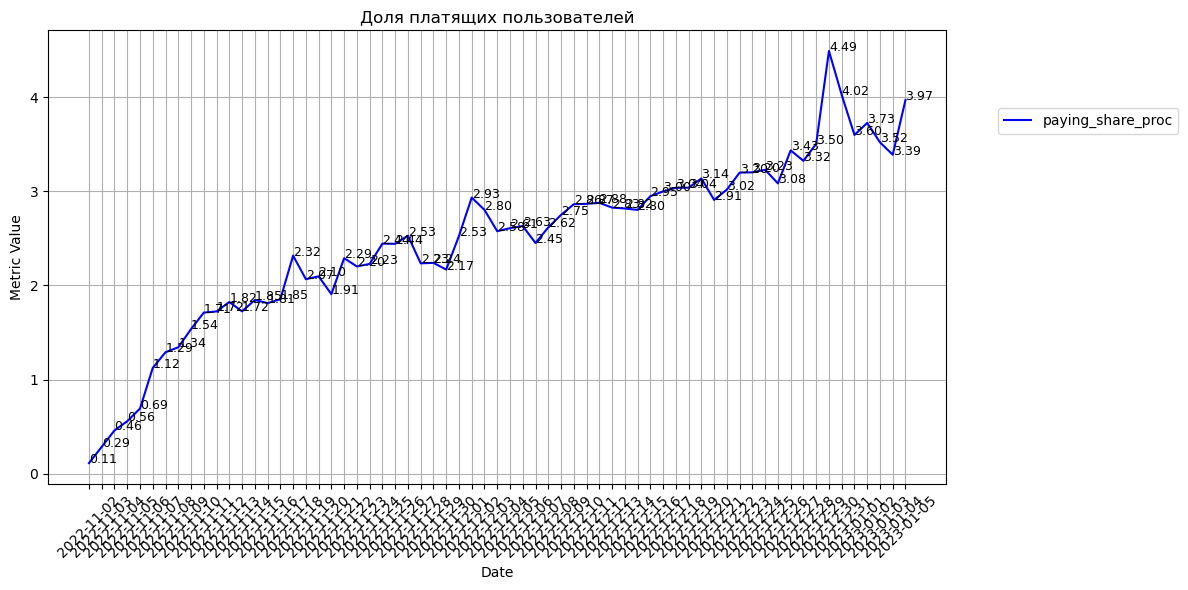

In [75]:
get_line_plot(df_users, 'date', ['paying_share_proc'], 'Доля платящих пользователей', annotate=True)

Sessions per User — среднее число сессий на пользователя


In [79]:
df_session = df_game.groupby(['date'], as_index=False) \
    .agg(all_users=('user', 'nunique'), session=('session_id','nunique'))
df_session

,date,all_users,session
0,2022-11-02,18710,37427
1,2022-11-03,48669,97522
2,2022-11-04,60913,122130
3,2022-11-05,77372,155317
4,2022-11-06,90436,181812
...,...,...,...
60,2023-01-01,13868,28405
61,2023-01-02,12667,26069
62,2023-01-03,9204,18827
63,2023-01-04,6434,13100


In [81]:
df_session['session_per_user'] = df_session['session']/df_session['all_users']
df_session

,date,all_users,session,session_per_user
0,2022-11-02,18710,37427,2.000374
1,2022-11-03,48669,97522,2.003781
2,2022-11-04,60913,122130,2.004991
3,2022-11-05,77372,155317,2.007406
4,2022-11-06,90436,181812,2.010394
...,...,...,...,...
60,2023-01-01,13868,28405,2.048241
61,2023-01-02,12667,26069,2.058025
62,2023-01-03,9204,18827,2.045524
63,2023-01-04,6434,13100,2.036058


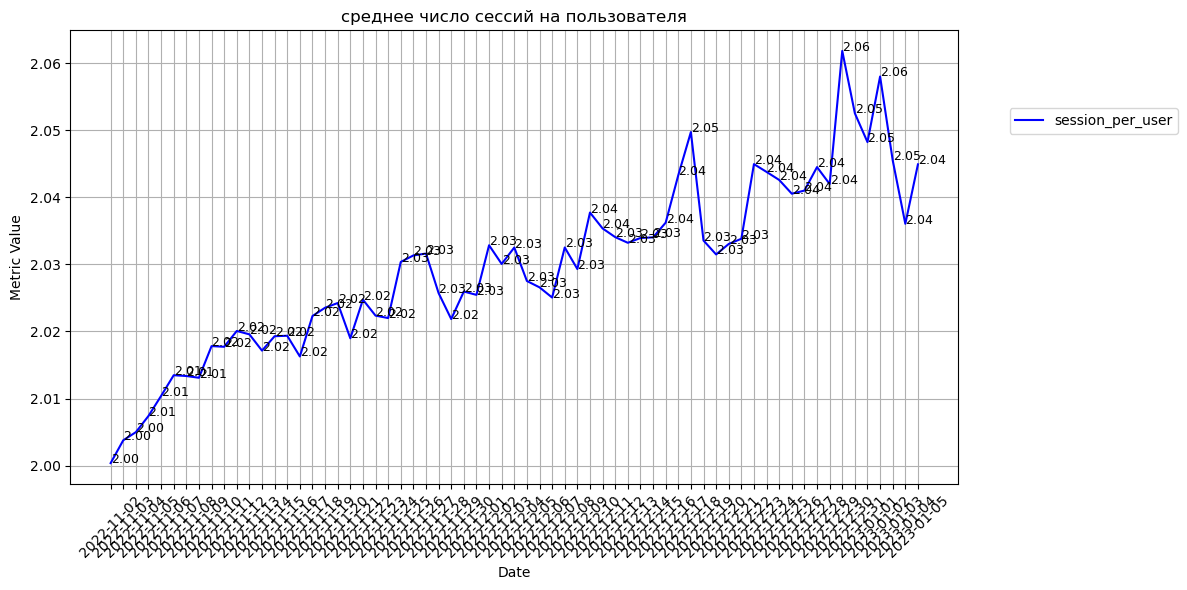

In [83]:
get_line_plot(df_session, 'date', ['session_per_user'], 'среднее число сессий на пользователя', annotate=True)

In [ ]:
Daily Play Time — среднее время, проводимое пользователем в игре в день (рассчитываем как общее время в приложении)


In [95]:
df_time2 = df_game.groupby(['date', 'user'], as_index=False) \
    .agg(session_time=('session_length_sec','sum'))
df_time2

,date,user,session_time
0,2022-11-02,005pSjmX,277
1,2022-11-02,00GX6KDn,1039
2,2022-11-02,00XrZ6pl,470
3,2022-11-02,00dsSs2C,1278
4,2022-11-02,00vvhf1W,143
...,...,...,...
1557186,2023-01-05,zuf7wfqF,5982
1557187,2023-01-05,zv5u4LJ1,1947
1557188,2023-01-05,zvUfP6Pi,8073
1557189,2023-01-05,zvqt5IUc,2842


In [97]:
df_time2 = df_time2.groupby(['date'], as_index=False) \
    .agg(session_time=('session_time','mean'))
df_time2

,date,session_time
0,2022-11-02,2712.152165
1,2022-11-03,4119.036717
2,2022-11-04,4878.156912
3,2022-11-05,5066.351639
4,2022-11-06,5499.326065
...,...,...
60,2023-01-01,7755.253389
61,2023-01-02,7868.969369
62,2023-01-03,6963.151999
63,2023-01-04,6565.358253


In [99]:
df_time2['session_min'] = df_time2['session_time']/60

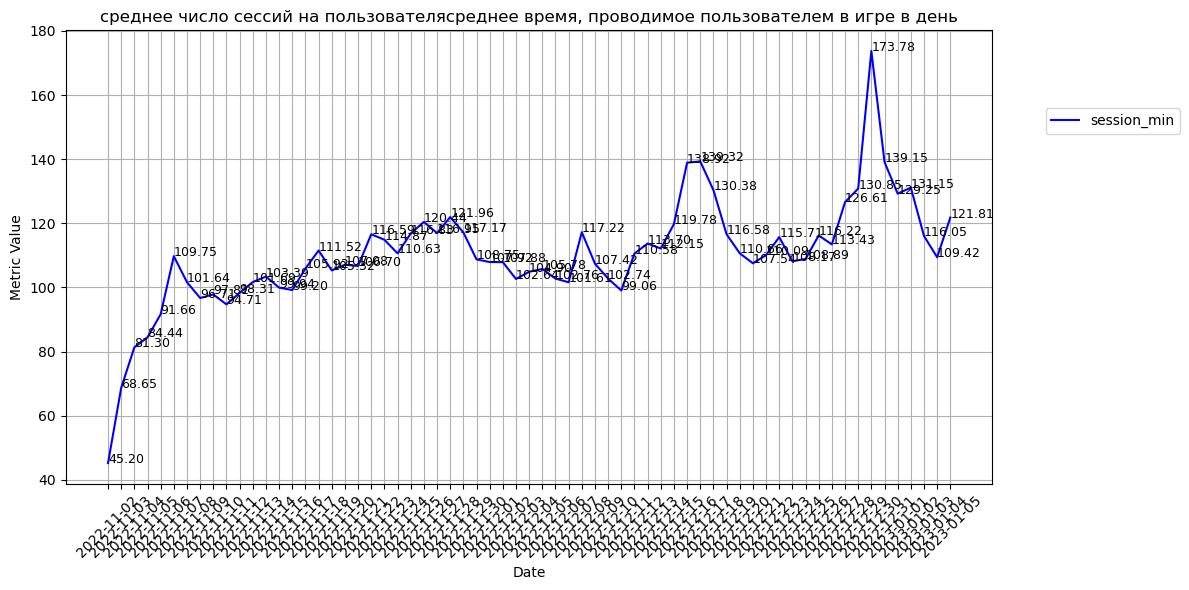

In [109]:
get_line_plot(df_time2, 'date', ['session_min'], 'среднее число сессий на пользователясреднее время, проводимое пользователем в игре в день', annotate=True)

Avg Attempts per Session — среднее число попыток на сессию

In [113]:
df_game.session_id.nunique()

3151378

In [115]:
len(df_game) #одна строка - одна сессия, значит можно просто взять среднее количество

3151378

In [119]:
df_attempts = df_game.groupby(['date'], as_index=False) \
    .agg(attempts_mean=('attempts','mean'))
df_attempts

,date,attempts_mean
0,2022-11-02,11.708689
1,2022-11-03,17.835239
2,2022-11-04,21.098199
3,2022-11-05,22.021859
4,2022-11-06,23.826230
...,...,...
60,2023-01-01,33.689223
61,2023-01-02,33.680501
62,2023-01-03,30.068588
63,2023-01-04,28.166073


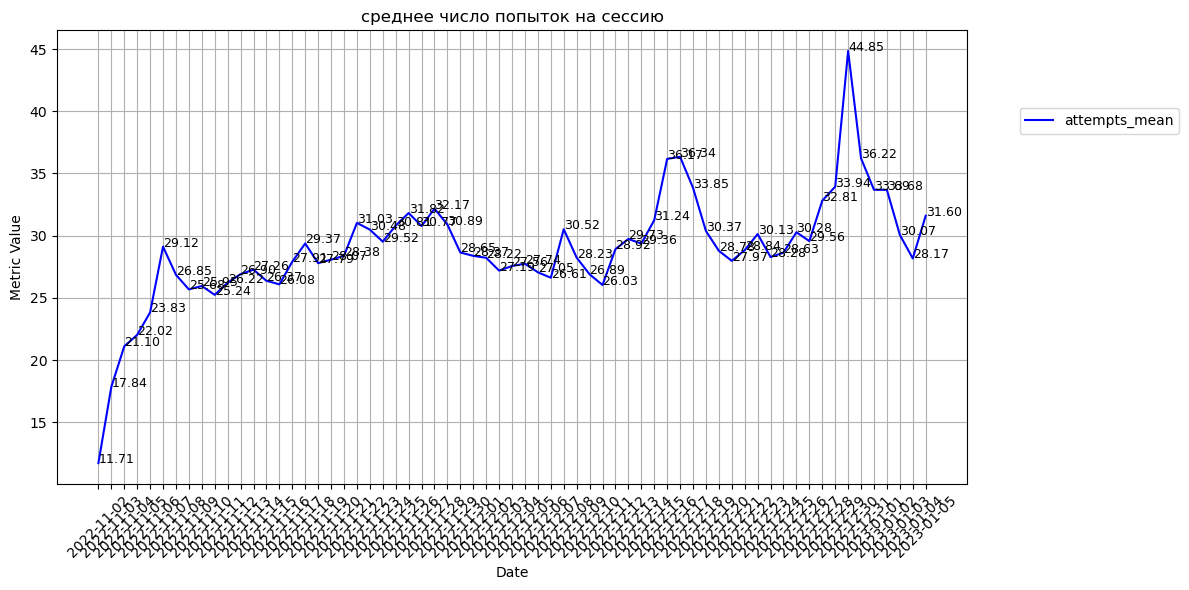

In [123]:
get_line_plot(df_attempts, 'date', ['attempts_mean'], 'среднее число попыток на сессию', annotate=True)

#### 2. Ride hailing  — 2 балла
У вас есть данные из приложения такси. Рассчитайте и визуализируйте:
- Ride Completion Rate — CR из заказа в завершенную поездку
- Acceptance Rate — доля заказов, принятых водителем (считаем, что приняты все заказы, кроме заказов со статусом 'No Driver Found')
- Cancellation Rate — доля отмененных заказов
- Rides per Driver — среднее число поездок на водителя
- Avg Ride Check — средний чек поездки
- Отношение RTA к ETA (что измеряет эта метрика?)

*Смотрим на подневную динамику

In [125]:
df_rh = pd.read_csv('hw_2_data/data/hw_2_taxi.csv')

In [127]:
df_rh.head()

,date,time,order_uid,order_status,passenger_id,vehicle_type,pickup_location,drop_location,ETA,RTA,...,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,fare,ride_distance,driver_ratings,customer_rating,payment_method
0,2024-01-01,00:19:34,2a11faf27f77eae8,Completed,CID8362794,Bike,Udyog Vihar,Ambience Mall,9.0,10.8,...,NaN,NaN,NaN,NaN,NaN,99.0,37.98,4.8,4.8,Cash
1,2024-01-01,01:35:18,33ed1f6bad78bdc8,Completed,CID8300238,Go Mini,Basai Dhankot,Madipur,6.0,8.5,...,NaN,NaN,NaN,NaN,NaN,114.0,39.29,4.2,4.1,Uber Wallet
2,2024-01-01,01:37:50,e2fc1fc520e93b85,Cancelled by Driver,CID2030746,Go Sedan,Tughlakabad,Greater Kailash,6.0,7.4,...,NaN,1.0,More than permitted people in there,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01,01:48:03,a130fd507acf7804,Cancelled by Driver,CID3231181,Auto,Palam Vihar,Kherki Daula Toll,5.0,NaN,...,NaN,1.0,Personal & Car related issues,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,01:49:56,cae2db8689a422fa,Cancelled by Driver,CID3381661,Go Sedan,Narsinghpur,Pulbangash,3.0,6.2,...,NaN,1.0,More than permitted people in there,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
df_rh.describe()

,ETA,RTA,cancelled_rides_by_customer,cancelled_rides_by_driver,incomplete_rides,fare,ride_distance,driver_ratings,customer_rating
count,139500.000000,125764.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,6.564122,8.284368,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.154810,3.660055,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,1.000000,2.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,4.000000,5.200000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,6.000000,8.100000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,9.000000,11.200000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,23.000000,20.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


In [131]:
df_rh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   date                               150000 non-null  object 
 1   time                               150000 non-null  object 
 2   order_uid                          150000 non-null  object 
 3   order_status                       150000 non-null  object 
 4   passenger_id                       150000 non-null  object 
 5   vehicle_type                       150000 non-null  object 
 6   pickup_location                    150000 non-null  object 
 7   drop_location                      150000 non-null  object 
 8   ETA                                139500 non-null  float64
 9   RTA                                125764 non-null  float64
 10  driver_id                          139500 non-null  object 
 11  cancelled_rides_by_customer        1050

Описание данных (уникальный ключ order_uid)

- date — дата создания заказа
- time — время создания заказа
- order_uid — уникальный идентификатор заказа
- order_status — статус заказа
- passenger_id — уникальный идентификатор пассажира
- vehicle_type — тип транспорта 
- pickup_location — место отправления
- drop_location — место назначения
- ETA — прогнозное время прибытия водителя на место отправления (estimated time of arrival)
- RTA — реальное время прибытия водителя на место отправления (real time of arrival)
- driver_id — уникальный идентификатор водителя
- cancelled_rides_by_customer — флаг отмены поездки пассажиром
- reason_for_cancelling_by_customer — причина отмены поездки пассажиром
- cancelled_rides_by_driver — флаг отмены поездки водителем
- driver_cancellation_reason — причина отмены поездки водителем
- incomplete_rides — флаг незавершенной поездки
- incomplete_rides_reason — причина незавершенной поездки
- fare — цена поездки
- ride_distance – расстояние поездки
- driver_ratings — рейтинг водителя
- customer_rating — рейтинг пассажира
- payment_method – способ оплаты


Ride Completion Rate — CR из заказа в завершенную поездку


In [137]:
#   завершенная это не отмененная и законченная и не имеющая флага незавершенная
df_rh[['incomplete_rides','cancelled_rides_by_customer', 'cancelled_rides_by_driver']] [df_rh.incomplete_rides.isna()]

,incomplete_rides,cancelled_rides_by_customer,cancelled_rides_by_driver
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,1.0
3,NaN,NaN,1.0
4,NaN,NaN,1.0
...,...,...,...
149994,NaN,NaN,1.0
149995,NaN,NaN,NaN
149996,NaN,NaN,NaN
149997,NaN,NaN,NaN


In [139]:
df_rh[['incomplete_rides','cancelled_rides_by_customer', 'cancelled_rides_by_driver']] [~df_rh.incomplete_rides.isna()]

,incomplete_rides,cancelled_rides_by_customer,cancelled_rides_by_driver
29,1.0,NaN,NaN
43,1.0,NaN,NaN
83,1.0,NaN,NaN
88,1.0,NaN,NaN
132,1.0,NaN,NaN
...,...,...,...
149968,1.0,NaN,NaN
149972,1.0,NaN,NaN
149982,1.0,NaN,NaN
149987,1.0,NaN,NaN


In [165]:
df_rh_cr = df_rh[df_rh.cancelled_rides_by_customer.isna()&df_rh.incomplete_rides.isna()&df_rh.cancelled_rides_by_driver.isna()]
df_rh_cr = df_rh_cr.groupby(['date'], as_index=False) \
    .agg(complete_rides=('order_uid','nunique'))
df_rh_cr

,date,complete_rides
0,2024-01-01,274
1,2024-01-02,272
2,2024-01-03,265
3,2024-01-04,283
4,2024-01-05,291
...,...,...
360,2024-12-26,264
361,2024-12-27,298
362,2024-12-28,277
363,2024-12-29,292


In [171]:
df_rh_all = df_rh.groupby(['date'], as_index=False) \
    .agg(all_rides=('order_uid','nunique'))
df_rh_all

,date,all_rides
0,2024-01-01,414
1,2024-01-02,389
2,2024-01-03,384
3,2024-01-04,414
4,2024-01-05,416
...,...,...
360,2024-12-26,369
361,2024-12-27,431
362,2024-12-28,391
363,2024-12-29,417


In [173]:
df_rh_all = pd.merge(df_rh_all,df_rh_cr, on='date' )

In [181]:
df_rh_all['cr_all_complete'] = df_rh_all['complete_rides']/  df_rh_all['all_rides']*100

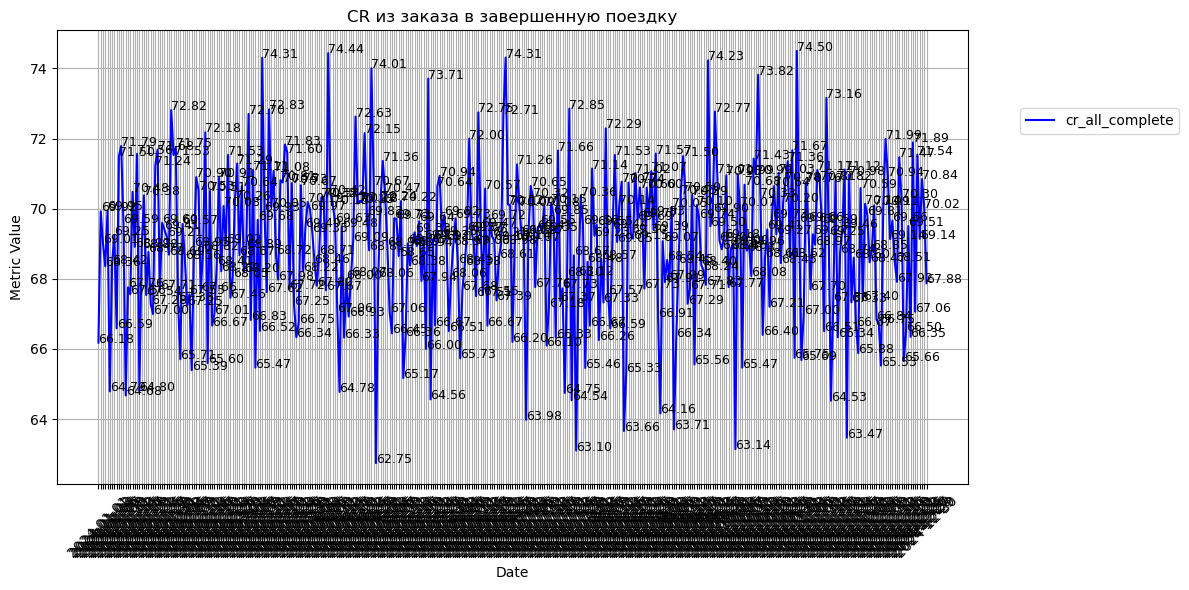

In [187]:
get_line_plot(df_rh_all, 'date', ['cr_all_complete'], 'CR из заказа в завершенную поездку', annotate=True)

Acceptance Rate — доля заказов, принятых водителем (считаем, что приняты все заказы, кроме заказов со статусом 'No Driver Found')


In [191]:
df_rh.order_status.unique()

array(['Completed', 'Cancelled by Driver', 'No Driver Found',
       'Cancelled by Customer', 'Incomplete'], dtype=object)

In [203]:
df_rh_drivers_found = df_rh[df_rh.order_status!='No Driver Found']
df_rh_drivers_found =  df_rh_drivers_found.groupby(['date'], as_index=False) \
    .agg(drivers_found=('order_uid','nunique'))
df_rh_drivers_found

,date,drivers_found
0,2024-01-01,391
1,2024-01-02,357
2,2024-01-03,364
3,2024-01-04,385
4,2024-01-05,382
...,...,...
360,2024-12-26,348
361,2024-12-27,398
362,2024-12-28,365
363,2024-12-29,392


In [207]:
df_rh_drivers_found= pd.merge(df_rh_drivers_found,df_rh_all[['date','all_rides']], on='date' )

In [211]:
df_rh_drivers_found['acceptance_rate'] = df_rh_drivers_found['drivers_found'] /df_rh_drivers_found['all_rides']*100

In [213]:
df_rh_drivers_found

,date,drivers_found,all_rides,acceptance_rate
0,2024-01-01,391,414,94.444444
1,2024-01-02,357,389,91.773779
2,2024-01-03,364,384,94.791667
3,2024-01-04,385,414,92.995169
4,2024-01-05,382,416,91.826923
...,...,...,...,...
360,2024-12-26,348,369,94.308943
361,2024-12-27,398,431,92.343387
362,2024-12-28,365,391,93.350384
363,2024-12-29,392,417,94.004796


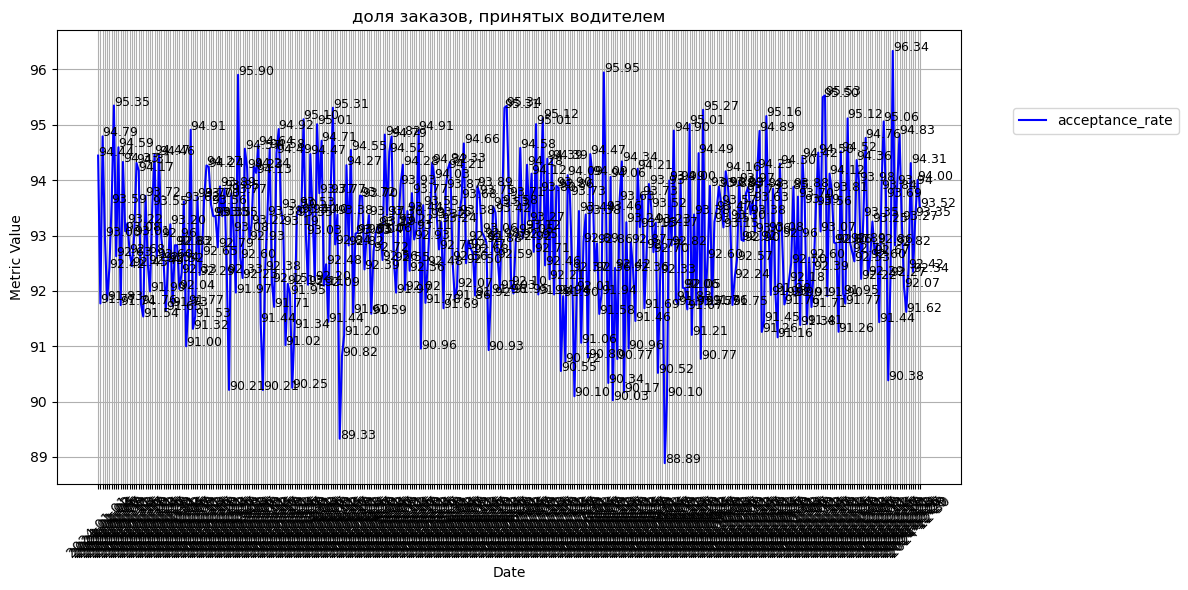

In [215]:
get_line_plot(df_rh_drivers_found, 'date', ['acceptance_rate'], 'доля заказов, принятых водителем', annotate=True)

In [ ]:
Cancellation Rate — доля отмененных заказов

Будем считать что по любой причине (отмена водителем или пассажиром) ||

In [289]:
df_rh.cancelled_rides_by_customer.unique()

array([nan,  1.])

In [293]:
df_rh[df_rh.cancelled_rides_by_customer==1.]

,date,time,order_uid,order_status,passenger_id,vehicle_type,pickup_location,drop_location,ETA,RTA,...,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,fare,ride_distance,driver_ratings,customer_rating,payment_method
11,2024-01-01,03:42:12,2c7efb5e0961116b,Cancelled by Customer,CID3958529,Go Mini,Anand Vihar,Khandsa,10.0,NaN,...,Driver asked to cancel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,2024-01-01,06:22:31,972fbcdb3a27ae23,Cancelled by Customer,CID7636784,Auto,Qutub Minar,Keshav Puram,11.0,13.8,...,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2024-01-01,06:23:32,130e220871ab56cd,Cancelled by Customer,CID8244156,Bike,Palam Vihar,Keshav Puram,14.0,16.8,...,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,2024-01-01,06:56:36,f7df765c5330cde1,Cancelled by Customer,CID6721208,Go Mini,Arjangarh,GTB Nagar,10.0,NaN,...,Driver asked to cancel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2024-01-01,07:09:46,6db71d047d0c5a39,Cancelled by Customer,CID6441086,eBike,Noida Film City,New Colony,7.0,NaN,...,Driver asked to cancel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149913,2024-12-30,18:48:59,0db24e6018c69ee8,Cancelled by Customer,CID8127103,eBike,Karkarduma,Indirapuram,8.0,11.4,...,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149942,2024-12-30,19:41:11,3663d0e5e880317f,Cancelled by Customer,CID6978617,Auto,Kaushambi,Indirapuram,8.0,NaN,...,Driver asked to cancel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149956,2024-12-30,20:25:18,328fce3a251d1189,Cancelled by Customer,CID6516960,eBike,Ardee City,Tilak Nagar,8.0,9.8,...,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149958,2024-12-30,20:34:33,356fd3fca135f6de,Cancelled by Customer,CID6919223,Bike,Kadarpur,Paharganj,9.0,NaN,...,Driver asked to cancel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
df_cancel = pd.concat([df_rh[(df_rh.cancelled_rides_by_driver==True)],df_rh[df_rh.cancelled_rides_by_customer==1.]])

In [299]:
df_cancel.order_status.unique()

array(['Cancelled by Driver', 'Cancelled by Customer'], dtype=object)

In [315]:
df_cancel = df_cancel.groupby(['date'], as_index=False) \
    .agg(cancel_ride=('order_uid','nunique'))
df_cancel

,date,cancel_ride
0,2024-01-01,119
1,2024-01-02,99
2,2024-01-03,95
3,2024-01-04,104
4,2024-01-05,100
...,...,...
360,2024-12-26,89
361,2024-12-27,110
362,2024-12-28,93
363,2024-12-29,102


In [317]:
df_cancel= pd.merge(df_cancel,df_rh_all[['date','all_rides']], on='date' )
df_cancel['cancel_rate'] = df_cancel['cancel_ride']/df_cancel['all_rides']*100
df_cancel

,date,cancel_ride,all_rides,cancel_rate
0,2024-01-01,119,414,28.743961
1,2024-01-02,99,389,25.449871
2,2024-01-03,95,384,24.739583
3,2024-01-04,104,414,25.120773
4,2024-01-05,100,416,24.038462
...,...,...,...,...
360,2024-12-26,89,369,24.119241
361,2024-12-27,110,431,25.522042
362,2024-12-28,93,391,23.785166
363,2024-12-29,102,417,24.460432


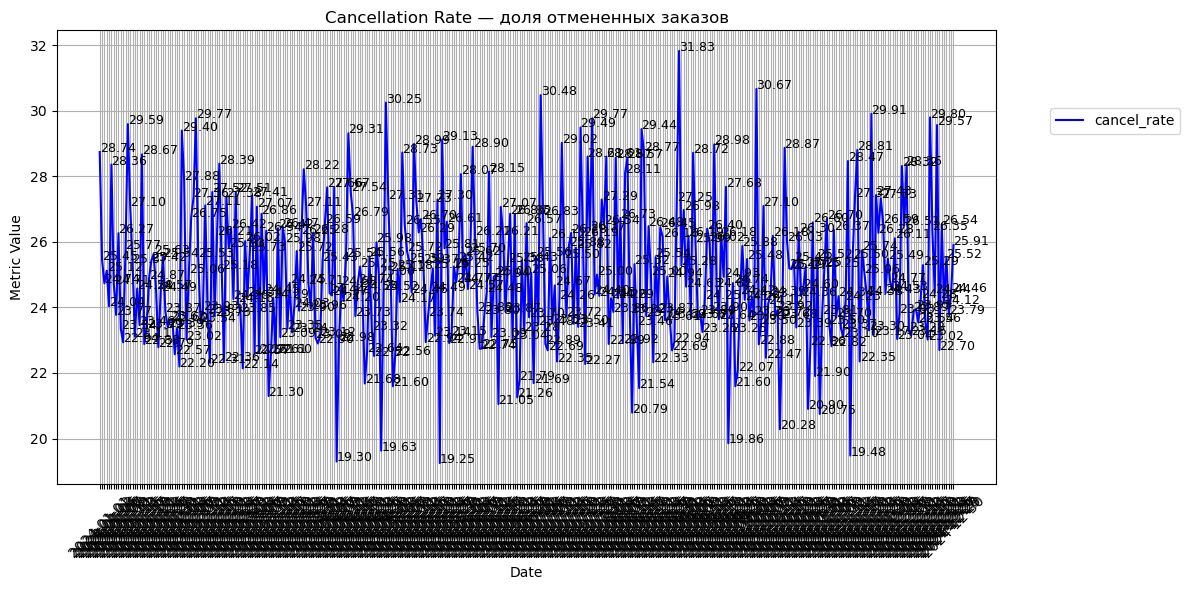

In [319]:
get_line_plot(df_cancel, 'date', ['cancel_rate'], 'Cancellation Rate — доля отмененных заказов', annotate=True)

In [ ]:
Rides per Driver — среднее число поездок на водителя

In [329]:
df_rides_rider = df_rh.groupby(['driver_id','date'], as_index=False) \
    .agg(rides=('order_uid','nunique'))
df_rides_rider

,driver_id,date,rides
0,A01-00001,2024-01-16,12
1,A01-00001,2024-02-03,7
2,A01-00001,2024-02-17,11
3,A01-00001,2024-02-21,4
4,A01-00001,2024-03-01,4
...,...,...,...
23448,UX07-00015,2024-12-01,5
23449,UX07-00015,2024-12-12,2
23450,UX07-00015,2024-12-17,4
23451,UX07-00015,2024-12-24,1


In [331]:
df_rides_rider = df_rides_rider.groupby(['date'], as_index=False) \
    .agg(mean_rides=('rides','mean'))
df_rides_rider

,date,mean_rides
0,2024-01-01,6.109375
1,2024-01-02,6.155172
2,2024-01-03,6.275862
3,2024-01-04,6.311475
4,2024-01-05,5.968750
...,...,...
360,2024-12-26,5.523810
361,2024-12-27,6.633333
362,2024-12-28,5.983607
363,2024-12-29,5.850746


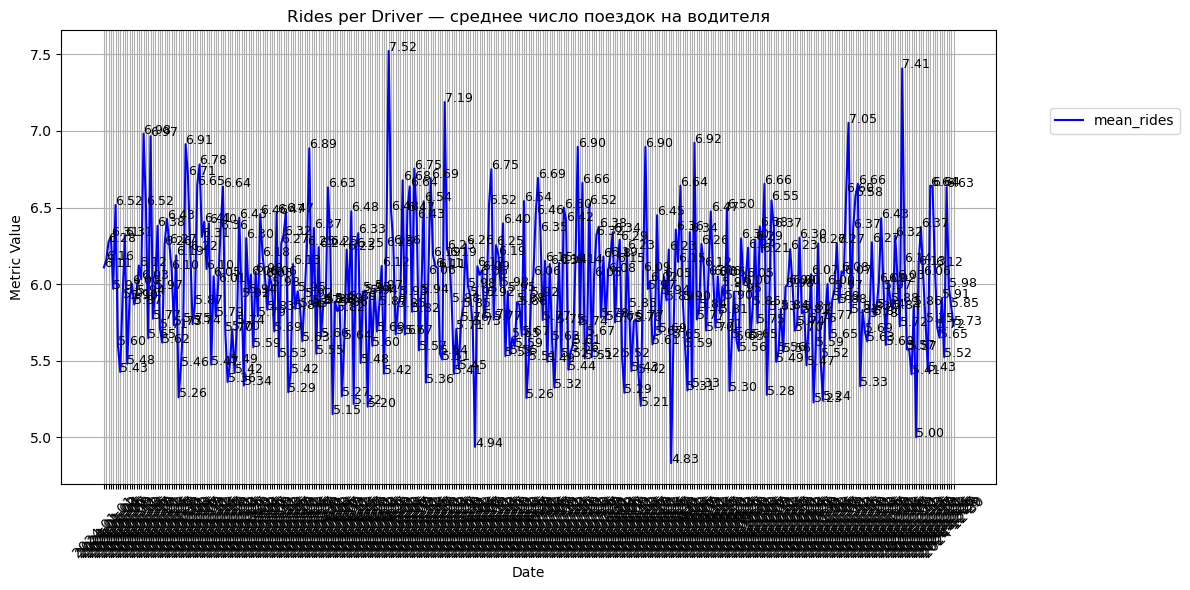

In [379]:
get_line_plot(df_rides_rider, 'date', ['mean_rides'], 'Rides per Driver — среднее число поездок на водителя', annotate=True)

Avg Ride Check — средний чек поездки

In [341]:
df_fare = df_rh.groupby(['date'], as_index=False) \
    .agg(fares=('fare','mean'))
df_fare

,date,fares
0,2024-01-01,456.091912
1,2024-01-02,439.639535
2,2024-01-03,434.877323
3,2024-01-04,416.530249
4,2024-01-05,474.085106
...,...,...
360,2024-12-26,472.420849
361,2024-12-27,475.736111
362,2024-12-28,688.937500
363,2024-12-29,741.210345


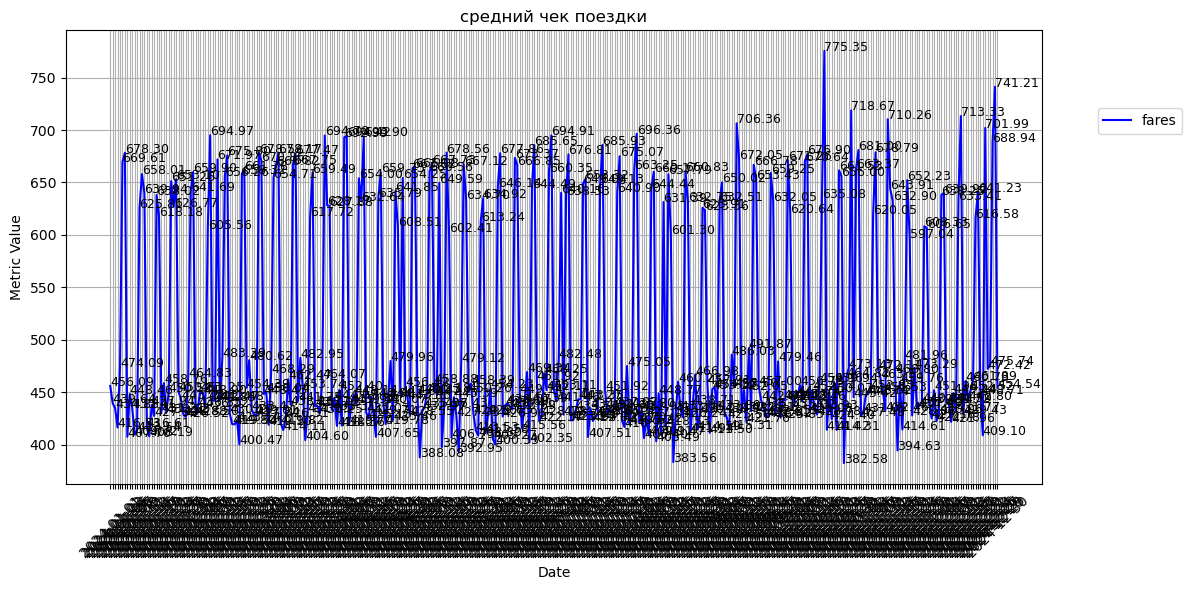

In [343]:
get_line_plot(df_fare, 'date', ['fares'], 'средний чек поездки', annotate=True)

Отношение RTA к ETA (что измеряет эта метрика?) 

- во сколько раз ошибаемся при прогнозировании времени прибытия


In [347]:
df_rh['rta_eta'] = df_rh['RTA'] /df_rh['ETA'] 

In [355]:
df_rh.head(1)

,date,time,order_uid,order_status,passenger_id,vehicle_type,pickup_location,drop_location,ETA,RTA,...,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,fare,ride_distance,driver_ratings,customer_rating,payment_method,rta_eta
0,2024-01-01,00:19:34,2a11faf27f77eae8,Completed,CID8362794,Bike,Udyog Vihar,Ambience Mall,9.0,10.8,...,NaN,NaN,NaN,NaN,99.0,37.98,4.8,4.8,Cash,1.2


In [351]:
df_rta_eta = df_rh.groupby(['date'], as_index=False) \
    .agg(rta_eta=('RTA','mean'))
df_rta_eta

,date,rta_eta
0,2024-01-01,7.837791
1,2024-01-02,8.142173
2,2024-01-03,7.945619
3,2024-01-04,8.241525
4,2024-01-05,8.467139
...,...,...
360,2024-12-26,8.423364
361,2024-12-27,8.344068
362,2024-12-28,8.231515
363,2024-12-29,8.043182


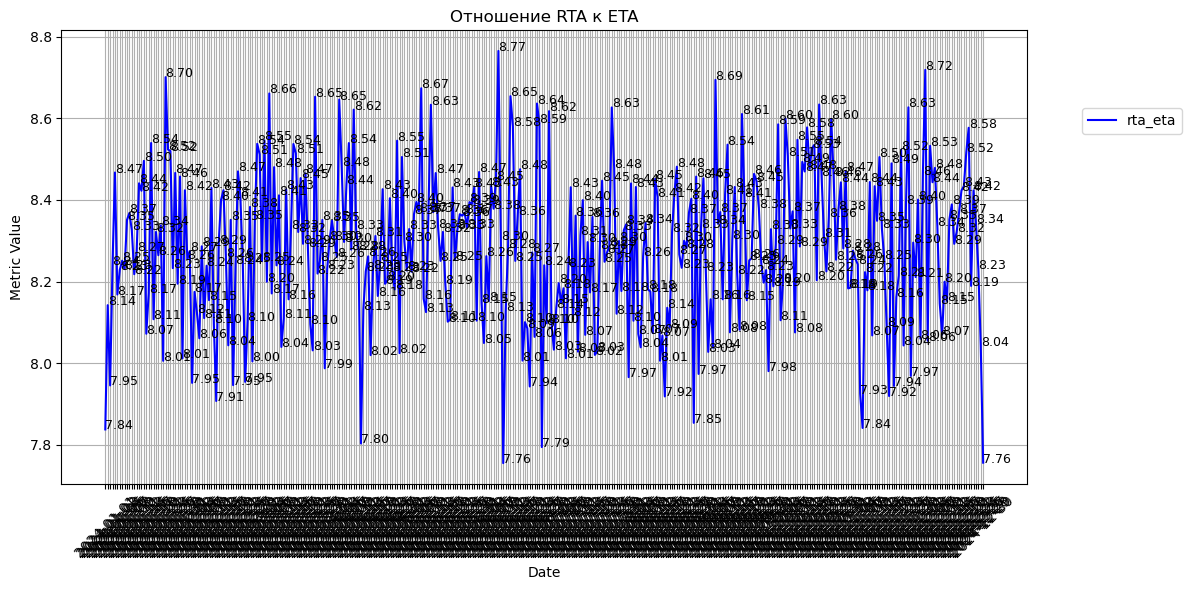

In [353]:
get_line_plot(df_rta_eta, 'date', ['rta_eta'], 'Отношение RTA к ETA', annotate=True)

### Case Study. Запуск подкастов в стриминговом сервисе 🎧

**Легенда**  
Вы работаете продуктовым аналитиком в музыкальном стриминговом сервисе. Недавно в продукте запустился раздел с подкастами. Команда, отвечающая за запуск, хочет понять, стоит ли масштабировать и продвигать этот формат.

In [42]:
df_music_logs = pd.read_parquet('hw_2_data/data/hw_2_streaming_logs.pqt')
df_music_subs = pd.read_parquet('hw_2_data/data/hw_2_streaming_subs.pqt')

In [44]:
df_music_logs.head()

,datetime,uid,item_id,played_ratio_pct,track_length_seconds,content_type,is_first_date
0,2024-01-13 10:00:00,468300,7400764,100,225,music,0.0
1,2024-01-13 10:00:05,347600,3415205,100,250,music,0.0
2,2024-01-13 10:00:10,942900,6728180,1,270,music,0.0
3,2024-01-13 10:00:15,243500,5283544,100,195,music,0.0
4,2024-01-13 10:00:15,12700,8932363,100,245,music,0.0


In [361]:
df_music_subs.head()

,uid,start_date,end_date
0,600,2024-08-08,NaT
1,700,2024-03-29,NaT
2,800,2024-06-13,NaT
3,1100,2024-11-19,NaT
4,1400,2024-12-01,NaT


Описание данных hw_2_streaming_logs:

- datetime — дата-время взаимодействия с контентом
- uid — уникальный идентификатор пользователя
- item_id — уникальный идентификатор трека/эпизода
- played_ratio_pct — процент от длительности, который был воспроизведен
- track_length_seconds – длина трека/эпизода в секундах
- content_type — тип контента: музыка или подкаст
- is_first_date — флаг, является ли эта дата первой для пользователя в продукте

Описание данных df_music_subs:

- uid — уникальный идентификатор пользователя
- start_date — дата начала подписки
- end_date — дата окончания подписки

#### 3. Метрики роста  — 2 балла

Рассчитайте и визуализируйте:
- DAU, MAU, WAU;
- Количество новых премиум-подписчиков (за неделю и месяц);
- Проникновение подкастов — долю юзеров, послушавших подкаст хотя бы раз (за неделю и месяц).

Сделайте выводы:
- Есть ли выраженный тренд?
- Нет ли подозрений, что с раскаткой раздела что-то могло пойти не так (изменение тренда, выраженные ступеньки)?
- Как выглядит адопшен? Можно ли предположить наличие каких-то эффектов в пользовательском взаимодействии с новым разделом?

In [371]:
df_music_logs['date'] = df_music_logs.datetime.dt.date

In [375]:
# your code is here
df_music_metric = df_music_logs.groupby(['date'], as_index=False) \
    .agg(dau=('uid','nunique'))
df_music_metric

,date,dau
0,2024-01-13,1985
1,2024-01-14,2547
2,2024-01-15,2342
3,2024-01-16,2471
4,2024-01-17,2549
...,...,...
297,2024-11-05,4777
298,2024-11-06,4818
299,2024-11-07,4935
300,2024-11-08,4913


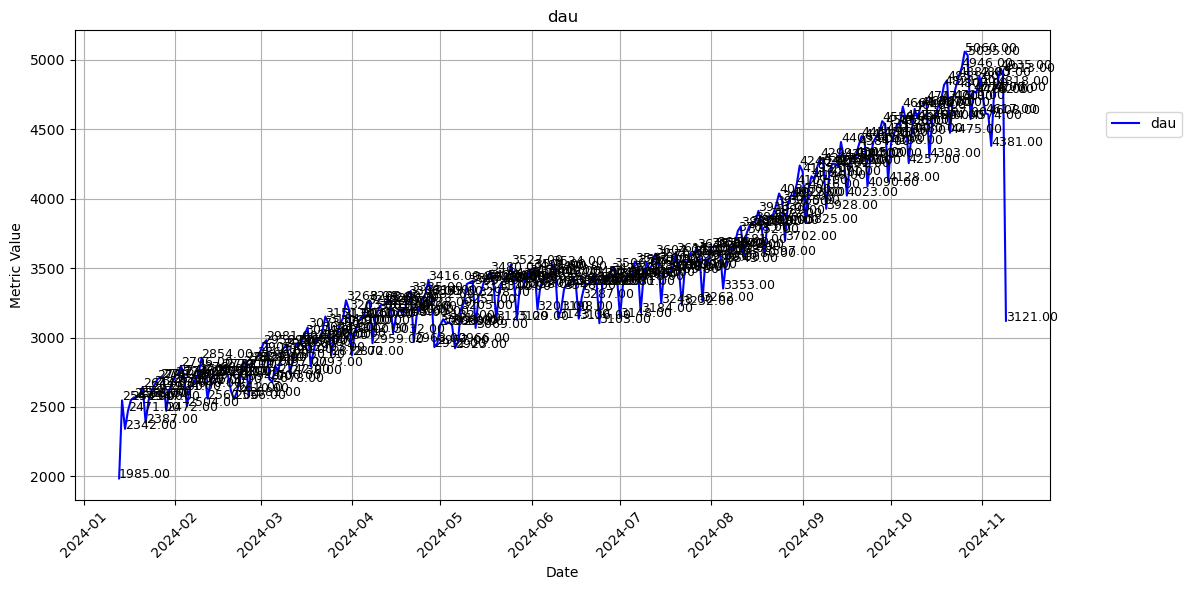

In [382]:
get_line_plot(df_music_metric, 'date', ['dau'], 'dau', annotate=True)

In [ ]:
MAU,

In [384]:
df_music_logs['month'] = df_music_logs.datetime.dt.month #все даты за один год , можно просто номер месяца

In [388]:
df_music_logs.datetime.min()

Timestamp('2024-01-13 10:00:00')

In [390]:
df_music_logs.datetime.max()

Timestamp('2024-11-09 08:13:20')

In [394]:
# your code is here
df_music_month = df_music_logs.groupby(['month'], as_index=False) \
    .agg(mau=('uid','nunique'))
df_music_month

,month,mau
0,1,4828
1,2,5299
2,3,5666
3,4,5961
4,5,6236
5,6,6460
6,7,6844
7,8,7376
8,9,8050
9,10,8846


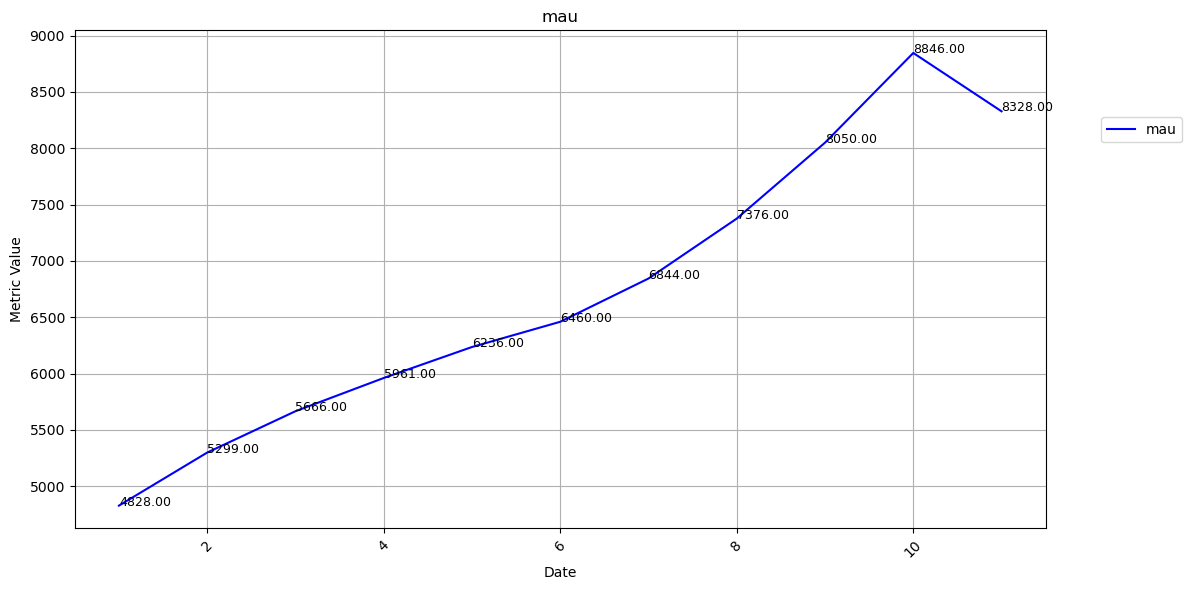

In [398]:
get_line_plot(df_music_month, 'month', ['mau'], 'mau', annotate=True)

есть явный тренд на рост аудитории

In [405]:
df_music_logs['week'] = df_music_logs.datetime.dt.to_period('W').apply(lambda r: r.start_time)


KeyboardInterrupt



In [408]:
df_music_logs

,datetime,uid,item_id,played_ratio_pct,track_length_seconds,content_type,is_first_date,date,month
0,2024-01-13 10:00:00,468300,7400764,100,225,music,0.0,2024-01-13,1
1,2024-01-13 10:00:05,347600,3415205,100,250,music,0.0,2024-01-13,1
2,2024-01-13 10:00:10,942900,6728180,1,270,music,0.0,2024-01-13,1
3,2024-01-13 10:00:15,243500,5283544,100,195,music,0.0,2024-01-13,1
4,2024-01-13 10:00:15,12700,8932363,100,245,music,0.0,2024-01-13,1
...,...,...,...,...,...,...,...,...,...
46384535,2024-11-09 08:13:15,554500,1011428,3,115,music,0.0,2024-11-09,11
46384536,2024-11-09 08:13:15,190700,875069,0,235,music,0.0,2024-11-09,11
46384537,2024-11-09 08:13:20,144700,6281650,6,205,music,0.0,2024-11-09,11
46384538,2024-11-09 08:13:20,687600,2092880,12,130,music,0.0,2024-11-09,11


In [ ]:
df_music_logs 

#### 4. Метрики продукта (шаг 1)  — 2 балла

Рассчитайте и визуализируйте как для всех пользователей в совокупности, так и для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами (грубо говоря разделяем юзеров на тех, кто слушает только музыку и тех, кто слушает еще и подкасты):
1. Среднее время прослушивания на пользователя.
2. Среднее число треков/эпизодов на пользователя (среднее число item_id). Посчитайте метрику, как от уникальных, так и от не уникальных item_id. Подумайте, что показывает каждая из них?
3. Долю премиум-подписчиков. Обратите внимание, что нам нужна активная подписка, если пользователь отписался в том же периоде, что подписался, мы больше не считаем подписку активной.

Рассчитайте и визуализируйте как по всем item_id, так и в разрезе типов контента:
- Долю дослушанных треков/эпизодов до конца. Обратите внимание, данная метрика уже не пользовательская.

Периоды — неделя и месяц. Неполные периоды нужно обрезать, если они мешают чтению графиков.   
Признак взаимодействия присвайвайте только для периода, когда оно действительно было.   
Для месячной динамики метрик по признаку взаимодействия с подкастами у вас получится всего 2 точки, такая визуализая тоже полезна, она сглаживает недельные колебания и помогает оценивать тренд в масштабе года.

Сделайте выводы:
- Есть ли выраженный тренд?
- Изменилась ли метрика после запуска подкастов?
- Отличается ли метрика сегмента, взаимодействовавшего с подкастами, от тех, кто слушал только музыку? (будьте аккуратны с выводами в этом пункте, мы не проверяем изменение на каузальность, поэтому не можем быть уверены где причина, а где следствие)
- Есть ли отличия между типами контента?

*За взаимодействие с подкастами давайте считать только прослушивание >= 30% или более 2х минут контента*

In [ ]:
df_music_logs

hассчитайте и визуализируйте как для всех пользователей в совокупности, так и для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами (грубо говоря разделяем юзеров на тех, кто слушает только музыку и тех, кто слушает еще и подкасты):
Среднее время прослушивания на пользователя.
Среднее число треков/эпизодов на пользователя (среднее число item_id). Посчитайте метрику, как от уникальных, так и от не уникальных item_id. Подумайте, что показывает каждая из них?
Долю премиум-подписчиков. Обратите внимание, что нам нужна активная подписка, если пользователь отписался в том же периоде, что подписался, мы больше не считаем подписку активной.

- datetime — дата-время взаимодействия с контентом
- uid — уникальный идентификатор пользователя
- item_id — уникальный идентификатор трека/эпизода
- played_ratio_pct — процент от длительности, который был воспроизведен
- track_length_seconds – длина трека/эпизода в секундах
- content_type — тип контента: музыка или подкаст
- is_first_date — флаг, является ли эта дата первой для пользователя в продукте

In [410]:
df_music_logs['played_time'] = df_music_logs['played_ratio_pct']* df_music_logs['track_length_seconds']/100

In [412]:
# your code is here
df_music_metric_prod = df_music_logs.groupby(['date'], as_index=False) \
    .agg(mean_all=('played_time','mean'), uniq_users = ('uid', 'nunique'), \
         played_rime = ('played_time', 'sum'), uniq_items =('item_id','nunique'),\
          cnt_items =('item_id','count')
        )
df_music_metric_prod

,date,mean_all,uniq_users,played_rime,uniq_items,cnt_items
0,2024-01-13,142.763029,1985,9287163.30,32118,65053
1,2024-01-14,134.122005,2547,14361918.45,42635,107081
2,2024-01-15,131.487494,2342,13350714.15,40538,101536
3,2024-01-16,135.554915,2471,13892481.05,42067,102486
4,2024-01-17,137.627235,2549,15152483.30,43562,110098
...,...,...,...,...,...,...
297,2024-11-05,133.744602,4777,28018156.65,67565,209490
298,2024-11-06,133.991314,4818,28514289.50,69643,212807
299,2024-11-07,134.193930,4935,29039566.35,68918,216400
300,2024-11-08,133.732823,4913,29292436.25,70632,219037


In [416]:
df_music_metric_prod_content_type= df_music_logs.groupby(['date','content_type'], as_index=False) \
    .agg(mean_all_type=('played_time','mean'), uniq_users_type = ('uid', 'nunique'), \
         played_rime_type = ('played_time', 'sum'), uniq_items_type =('item_id','nunique'),\
          cnt_items_type =('item_id','count') )
df_music_metric_prod_content_type

,date,content_type,mean_all_type,uniq_users_type,played_rime_type,uniq_items_type,cnt_items_type
0,2024-01-13,music,142.763029,1985,9287163.30,32118,65053
1,2024-01-14,music,134.122005,2547,14361918.45,42635,107081
2,2024-01-15,music,131.487494,2342,13350714.15,40538,101536
3,2024-01-16,music,135.554915,2471,13892481.05,42067,102486
4,2024-01-17,music,137.627235,2549,15152483.30,43562,110098
...,...,...,...,...,...,...,...
367,2024-11-07,podcast,254.436309,247,421855.40,461,1658
368,2024-11-08,music,132.346210,4888,28885751.55,70181,218259
369,2024-11-08,podcast,522.730977,248,406684.70,451,778
370,2024-11-09,music,121.790050,3095,10698646.95,38511,87845


In [418]:
df_music_metric_prod = pd.merge(df_music_metric_prod,df_music_metric_prod_content_type, on='date' )

In [420]:
df_music_metric_prod

,date,mean_all,uniq_users,played_rime,uniq_items,cnt_items,content_type,mean_all_type,uniq_users_type,played_rime_type,uniq_items_type,cnt_items_type
0,2024-01-13,142.763029,1985,9287163.30,32118,65053,music,142.763029,1985,9287163.30,32118,65053
1,2024-01-14,134.122005,2547,14361918.45,42635,107081,music,134.122005,2547,14361918.45,42635,107081
2,2024-01-15,131.487494,2342,13350714.15,40538,101536,music,131.487494,2342,13350714.15,40538,101536
3,2024-01-16,135.554915,2471,13892481.05,42067,102486,music,135.554915,2471,13892481.05,42067,102486
4,2024-01-17,137.627235,2549,15152483.30,43562,110098,music,137.627235,2549,15152483.30,43562,110098
...,...,...,...,...,...,...,...,...,...,...,...,...
367,2024-11-07,134.193930,4935,29039566.35,68918,216400,podcast,254.436309,247,421855.40,461,1658
368,2024-11-08,133.732823,4913,29292436.25,70632,219037,music,132.346210,4888,28885751.55,70181,218259
369,2024-11-08,133.732823,4913,29292436.25,70632,219037,podcast,522.730977,248,406684.70,451,778
370,2024-11-09,302.128237,3121,29500707.45,38771,97643,music,121.790050,3095,10698646.95,38511,87845


In [11]:
# your code is here

Долю премиум-подписчиков. Обратите внимание, что нам нужна активная подписка, если пользователь отписался в том же периоде, что подписался, мы больше не считаем подписку активной.

In [ ]:

Описание данных df_music_subs:

- uid — уникальный идентификатор пользователя
- start_date — дата начала подписки
- end_date — дата окончания подписки

In [426]:
df_music_subs.start_date

0      2024-08-08
1      2024-03-29
2      2024-06-13
3      2024-11-19
4      2024-12-01
          ...    
3598   2024-03-07
3599   2024-05-18
3600   2024-11-02
3601   2024-06-05
3602   2024-04-22
Name: start_date, Length: 3603, dtype: datetime64[ns]

In [428]:
df_music_subs['start_month'] = df_music_subs.start_date.dt.month 
df_music_subs['end_month'] = df_music_subs.end_date.dt.month 

In [430]:
df_music_subs_pay = df_music_subs[df_music_subs.start_month != df_music_subs.end_month]

собрать таблицу наджойнить на календарь, месяц - активные подписчики (если end>= месяц >= старта )

In [436]:
df_music_subs.start_date.min()

Timestamp('2024-01-13 00:00:00')

In [438]:
df_music_subs.end_date.max()

Timestamp('2024-11-09 00:00:00')

In [48]:
# 1) Логи: дата как datetime64[ns] с 00:00:00  
df_music_logs['date'] = pd.to_datetime(df_music_logs['datetime']).dt.normalize() # оставляем только дату

active_users = (
    df_music_logs.groupby('date')['uid']
    .nunique()
    .rename('active_users')
    .reset_index()
)

# 2) Подписки 
df_music_subs['start_date'] = pd.to_datetime(df_music_subs['start_date']).dt.normalize() # оставляем только дату
df_music_subs['end_date']   = pd.to_datetime(df_music_subs['end_date']).dt.normalize() # оставляем только дату

# Выкидываем нулевые по длительности подписки (start == end)
subs = df_music_subs.query('start_date < end_date')

# 3) Разворачиваем дни активности подписки (end не включаем)
subs['date_range'] = subs.apply(
    lambda r: pd.date_range(r.start_date, r.end_date - pd.Timedelta(days=1), freq='D'),
    axis=1
)
subs_expanded = subs.explode('date_range', ignore_index=True).rename(columns={'date_range': 'date'})
active_subs = (
    subs_expanded.groupby('date')['uid']
    .nunique()
    .rename('active_subs')
    .reset_index()
)

#  доля
df_ratio = (
    active_users.merge(active_subs, on='date', how='left')
    .fillna({'active_subs': 0})
)
df_ratio['premium_share'] = df_ratio['active_subs'] / df_ratio['active_users']


In [52]:
df_ratio['premium_share_proc'] = df_ratio['premium_share']*100
df_ratio

,date,active_users,active_subs,premium_share,premium_share_proc
0,2024-01-13,1985,1.0,0.000504,0.050378
1,2024-01-14,2547,2.0,0.000785,0.078524
2,2024-01-15,2342,2.0,0.000854,0.085397
3,2024-01-16,2471,2.0,0.000809,0.080939
4,2024-01-17,2549,2.0,0.000785,0.078462
...,...,...,...,...,...
297,2024-11-05,4777,5.0,0.001047,0.104668
298,2024-11-06,4818,5.0,0.001038,0.103778
299,2024-11-07,4935,5.0,0.001013,0.101317
300,2024-11-08,4913,3.0,0.000611,0.061062


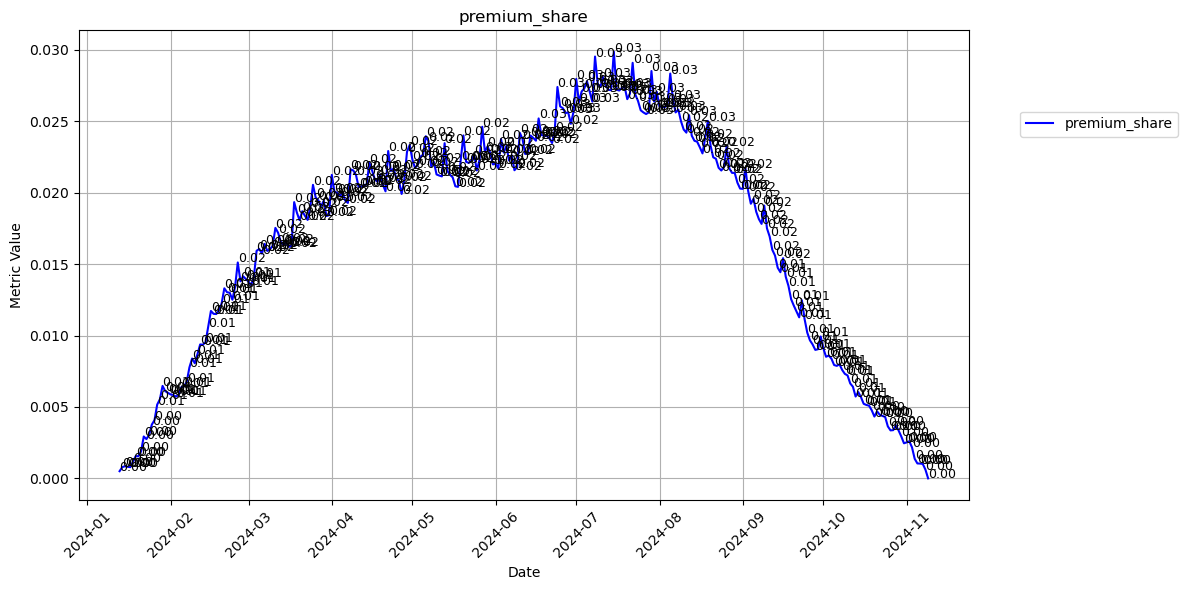

In [54]:
get_line_plot(df_ratio, 'date', ['premium_share'], 'premium_share', annotate=True)

тревожная динамика

#### 5. Метрики продукта (шаг 2)  — 2 балла

Рассчитайте и визуализируйте:
1) D1, D7, D30 retention по всем пользователям. Когорты агрегируйте по неделям т.к. из-за низкого числа новичков на дневном разрезе визуализации слишком шумные.
2) D30 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 30 дня. Когорты агрегируйте по неделям.
3) D7 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 7 дня. Когорты агрегируйте по месяцам.

Для наглядности будет полезно нарисовать на одном графике как посегментную, так и общую динамику (для этого можете достроить D7 retention для всех пользователей с помесячной агрегацией).

Сделайте выводы: 
- Есть ли выраженный тренд?
- Изменилась ли метрика после запуска подкастов?
- Отличается ли метрика сегмента, взаимодействовавшего с подкастами, от тех, кто слушал только музыку? (будьте аккуратны с выводами в этом пункте, мы не проверяем изменение на каузальность, поэтому не можем быть уверены где причина, а где следствие)

*За взаимодействие с подкастами давайте считать только прослушивание >= 30% или более 2х минут контента*

1. D1, D7, D30 retention по всем пользователям. Когорты агрегируйте по неделям т.к. из-за низкого числа новичков на дневном разрезе визуализации слишком шумные.

In [97]:
 
# 0) Подготовка дат (день без времени)
df_music_logs['date'] = pd.to_datetime(df_music_logs['datetime']).dt.normalize()

# 1) Дата первой активности пользователя
first_seen = (
    df_music_logs.groupby('uid', sort=False)['date']
    .min()
    .rename('first_date')
)

# 2) Присоединяем first_date и считаем смещение по дням
df = df_music_logs.merge(first_seen, on='uid', how='left')
df['day_offset'] = (df['date'] - df['first_date']).dt.days

# 3) Недельная когорта (начало недели = понедельник) — без lambda
# вариант А (чистая арифметика):
df['cohort_week'] = df['first_date'] - pd.to_timedelta(df['first_date'].dt.weekday, unit='D')
# (альтернатива ещё быстрее на больших объёмах)
# df['cohort_week'] = df['first_date'].values.astype('datetime64[W]').astype('datetime64[ns]')

# 4) Считаем количество уникальных пользователей по (cohort_week, day_offset)
ret_counts = (
    df.groupby(['cohort_week', 'day_offset'], as_index=False)['uid']
      .nunique()
      .rename(columns={'uid': 'users'})
)

# 5) Размер когорты = users при day_offset == 0
cohort_sizes = (
    ret_counts.loc[ret_counts['day_offset'].eq(0), ['cohort_week', 'users']]
               .rename(columns={'users': 'cohort_size'})
)

# 6) Берём только нужные сдвиги и считаем retention
wanted_offsets = [0, 1, 7, 30]
retention = ret_counts[ret_counts['day_offset'].isin(wanted_offsets)].merge(
    cohort_sizes, on='cohort_week', how='left'
)
retention['retention'] = retention['users'] / retention['cohort_size']

# 7) Пивот: строки — когорта недели, колонки — D0/D1/D7/D30
retention_pivot = (
    retention.pivot(index='cohort_week', columns='day_offset', values='retention')
             .rename(columns={0: 'D0', 1: 'D1', 7: 'D7', 30: 'D30'})
             .sort_index()
             .reset_index()
)

# Опционально: если нужна только метрика без D0
retention_pivot = retention_pivot[['cohort_week', 'D1', 'D7', 'D30']]


In [98]:
retention_pivot

day_offset,cohort_week,D1,D7,D30
0,2024-01-08,0.721157,0.696603,0.602758
1,2024-01-15,0.453593,0.393713,0.370509
2,2024-01-22,0.375000,0.280000,0.265000
3,2024-01-29,0.363636,0.236364,0.210909
4,2024-02-05,0.371728,0.282723,0.251309
5,2024-02-12,0.375887,0.297872,0.269504
6,2024-02-19,0.360759,0.278481,0.272152
7,2024-02-26,0.424658,0.212329,0.294521
8,2024-03-04,0.400000,0.323077,0.292308
9,2024-03-11,0.449275,0.478261,0.384058


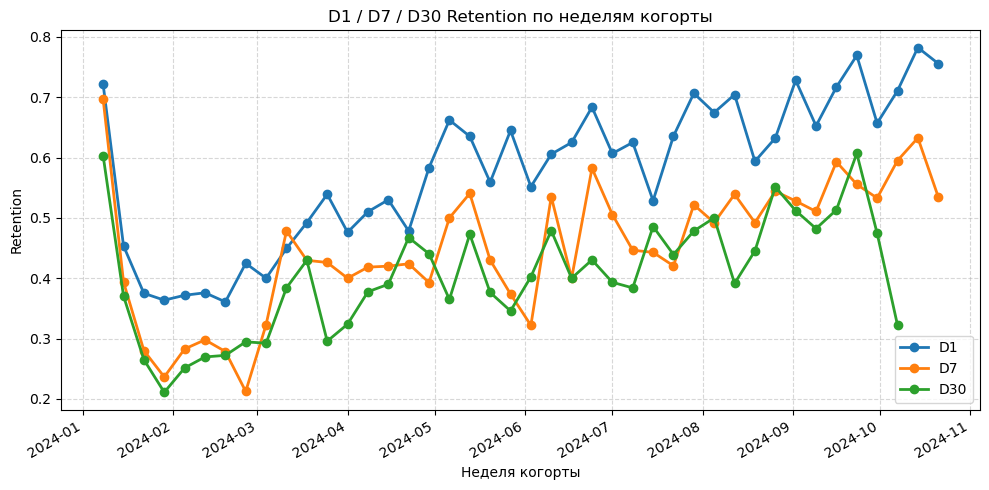

In [105]:
# График: одна ось, три линии D1/D7/D30
fig, ax = plt.subplots(figsize=(10, 5))
for col in ['D1', 'D7', 'D30']:
    ax.plot(retention_pivot['cohort_week'], retention_pivot[col], label=col, marker='o', linewidth=2)

ax.set_title('D1 / D7 / D30 Retention по неделям когорты')
ax.set_xlabel('Неделя когорты')
ax.set_ylabel('Retention')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

D30 retention  особенно грустно выглядит

2. D30 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 30 дня. Когорты агрегируйте по неделям.

In [74]:
df

,datetime,uid,item_id,played_ratio_pct,track_length_seconds,content_type,is_first_date,date,first_date,cohort_week,day_offset
0,2024-01-13 10:00:00,468300,7400764,100,225,music,0.0,2024-01-13,2024-01-13,2024-01-08,0
1,2024-01-13 10:00:05,347600,3415205,100,250,music,0.0,2024-01-13,2024-01-13,2024-01-08,0
2,2024-01-13 10:00:10,942900,6728180,1,270,music,0.0,2024-01-13,2024-01-13,2024-01-08,0
3,2024-01-13 10:00:15,243500,5283544,100,195,music,0.0,2024-01-13,2024-01-13,2024-01-08,0
4,2024-01-13 10:00:15,12700,8932363,100,245,music,0.0,2024-01-13,2024-01-13,2024-01-08,0
...,...,...,...,...,...,...,...,...,...,...,...
46384535,2024-11-09 08:13:15,554500,1011428,3,115,music,0.0,2024-11-09,2024-01-14,2024-01-08,300
46384536,2024-11-09 08:13:15,190700,875069,0,235,music,0.0,2024-11-09,2024-05-19,2024-05-13,174
46384537,2024-11-09 08:13:20,144700,6281650,6,205,music,0.0,2024-11-09,2024-06-23,2024-06-17,139
46384538,2024-11-09 08:13:20,687600,2092880,12,130,music,0.0,2024-11-09,2024-10-18,2024-10-14,22


In [129]:
df.content_type.unique()

array(['music', 'podcast'], dtype=object)

In [ ]:
 
from matplotlib.ticker import PercentFormatter

# ===  
df_music_logs['date'] = pd.to_datetime(df_music_logs['datetime']).dt.normalize()

# first_date для каждого uid
first_seen = df_music_logs.groupby('uid', sort=False)['date'].min().rename('first_date')
df = df_music_logs.merge(first_seen, on='uid', how='left')
df['day_offset'] = (df['date'] - df['first_date']).dt.days

# Недельная когорта: начало недели = понедельник  
df['cohort_week'] = df['first_date'].values.astype('datetime64[W]').astype('datetime64[ns]')

# === 1) Сегмент «podcast в 0..30 дней» по правилу ≥30% или ≥120 сек ===
ct = df['content_type'].astype(str).str.lower()
is_podcast_ct = ct.eq('podcast')
in_0_30 = df['day_offset'].between(0, 30)

# Нормализация played_ratio_pct к шкале 0..1 (поддерживает 45, 0.45, "45%")
pr_series = pd.to_numeric(
    df['played_ratio_pct'].astype(str)
                          .str.replace('%','', regex=False)
                          .str.replace(',','.', regex=False),
    errors='coerce'
)
if pr_series.max(skipna=True) > 1:
    pr01 = (pr_series / 100.0).clip(0, 1)
else:
    pr01 = pr_series.fillna(0).clip(0, 1)

# Секунды прослушивания
tls = pd.to_numeric(df['track_length_seconds'], errors='coerce')
has_len = tls.notna() & (tls > 0)
tls = tls.fillna(0)
listened_sec = pr01.to_numpy(copy=False) * tls.to_numpy(copy=False)

mask_percent_ok = pr01 >= 0.30
mask_seconds_ok = has_len & (listened_sec >= 120)

mask_podcast_0_30 = is_podcast_ct & in_0_30 & (mask_percent_ok | mask_seconds_ok)

# uids, у которых был «валидный» подкаст в 0..30 дней
podcast_uids = pd.Index(df.loc[mask_podcast_0_30, 'uid'].unique())

# === 2) user_map: uid → cohort_week, segment (podcast / no_podcast) ===
user_first = df[['uid', 'first_date']].drop_duplicates('uid')
user_first['cohort_week'] = user_first['first_date'] - pd.to_timedelta(user_first['first_date'].dt.weekday, unit='D')
# альтернатива:
 

user_map = user_first[['uid', 'cohort_week']].copy()
flag = pd.Series(1, index=podcast_uids, name='flag')
user_map['segment'] = np.where(user_map['uid'].map(flag).fillna(0).astype('uint8').eq(1), 'podcast', 'no_podcast')

# === 3) Размеры когорт по сегментам (коэффициент для деления) ===
cohort_sizes = (
    user_map.groupby(['cohort_week', 'segment'], observed=True)['uid']
            .nunique()
            .rename('cohort_size')
            .reset_index()
)

# === 4) Активные на 30-й день (day_offset == 30) по сегментам и когортам ===
uid_to_cohort  = user_map.set_index('uid')['cohort_week']
uid_to_segment = user_map.set_index('uid')['segment']

d30_uids = df.loc[df['day_offset'].eq(30), 'uid'].drop_duplicates()

# Быстро через crosstab, без тяжёлых merge
active_d30 = (
    pd.crosstab(d30_uids.map(uid_to_cohort).rename('cohort_week'),
                d30_uids.map(uid_to_segment).rename('segment'))
      .stack()
      .to_frame('active_d30')
      .reset_index()
)

# === 5) D30 retention и pivot ===
retention = cohort_sizes.merge(active_d30, on=['cohort_week','segment'], how='left')
retention['active_d30'] = retention['active_d30'].fillna(0)
retention['D30_retention'] = np.where(
    retention['cohort_size'].gt(0),
    retention['active_d30'] / retention['cohort_size'],
    np.nan
)

retention_pivot_seg = (
    retention.pivot(index='cohort_week', columns='segment', values='D30_retention')
             .reindex(columns=['podcast', 'no_podcast'])     #  два столбца
             .sort_index()
             .reset_index()
)

print(retention_pivot_seg.head())

# === 6) График: две линии на одной оси ===
fig, ax = plt.subplots(figsize=(10, 5))
if 'podcast' in retention_pivot_seg.columns:
    ax.plot(retention_pivot_seg['cohort_week'], retention_pivot_seg['podcast'],
            marker='o', linewidth=2, label='podcast')
if 'no_podcast' in retention_pivot_seg.columns:
    ax.plot(retention_pivot_seg['cohort_week'], retention_pivot_seg['no_podcast'],
            marker='o', linewidth=2, label='no_podcast')

ax.set_title('D30 retention по недельным когортам: podcast vs no_podcast')
ax.set_xlabel('Cohort week (Monday start)')
ax.set_ylabel('D30 retention')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


пу пу пу

3. D7 retention для сегментов пользователей в разрезе — сделали / не сделали взаимодействие с подкастами на промежутке до 7 дня. Когорты агрегируйте по месяцам.

In [141]:
 
print('Уникальные content_type:', df['content_type'].dropna().str.lower().value_counts().head())


Уникальные content_type: content_type
music      46325679
podcast       58861
Name: count, dtype: int64


 
df_music_logs['date'] = pd.to_datetime(df_music_logs['datetime']).dt.normalize()
first_seen = df_music_logs.groupby('uid', sort=False)['date'].min().rename('first_date')
df = df_music_logs.merge(first_seen, on='uid', how='left')
df['day_offset'] = (df['date'] - df['first_date']).dt.days

In [145]:


# 1) Когорта по месяцам (первое число месяца), векторно
df['cohort_month'] = df['first_date'].values.astype('datetime64[M]').astype('datetime64[ns]')

# 2) Флаг "podcast" и окно 0..7
is_podcast_ct = df['content_type'].astype(str).str.lower().eq('podcast')
in_0_7 = df['day_offset'].between(0, 7)

# 3) Нормализация процента В МАСШТАБЕ СТОЛБЦА
#    Если в колонке встречаются значения > 1, считаем шкалу 0..100 и делим ВСЕ на 100 (включая 1 -> 0.01)
pr_series = pd.to_numeric(df['played_ratio_pct'].astype(str).str.replace('%','', regex=False)
                          .str.replace(',','.', regex=False), errors='coerce')
if pr_series.max(skipna=True) > 1:
    pr01 = (pr_series / 100.0).clip(lower=0, upper=1)   # 0..1
else:
    pr01 = pr_series.fillna(0).clip(lower=0, upper=1)   # уже 0..1

# 4) Секунды прослушивания (если длины нет — учитываем только порог по %)
tls = pd.to_numeric(df['track_length_seconds'], errors='coerce')
has_len = tls.notna() & (tls > 0)
tls = tls.fillna(0)
listened_sec = pr01.to_numpy(copy=False) * tls.to_numpy(copy=False)

mask_podcast_0_7 = is_podcast_ct & in_0_7 & ((pr01 >= 0.30) | (has_len & (listened_sec >= 120)))

# 5) user_map: uid → cohort_month, segment (минимум merge’ов)
podcast_uids = pd.Index(df.loc[mask_podcast_0_7, 'uid'].unique())

user_first = df[['uid','first_date']].drop_duplicates('uid')
user_first['cohort_month'] = user_first['first_date'].values.astype('datetime64[M]').astype('datetime64[ns]')
user_map = user_first[['uid','cohort_month']].copy()

flag = pd.Series(1, index=podcast_uids, name='flag')
user_map['segment'] = np.where(user_map['uid'].map(flag).fillna(0).astype('uint8').eq(1),
                               'podcast', 'no_podcast')

# 5a) sanity-check: убедимся, что оба сегмента есть
print('segment counts:\n', user_map['segment'].value_counts(dropna=False))

# 6) Размер когорты по сегментам
cohort_sizes = (user_map.groupby(['cohort_month','segment'], observed=True)['uid']
                        .nunique().rename('cohort_size').reset_index())

# 7) Активные на 7-й день (любой контент) — быстро через map + crosstab
uid_to_cohort  = user_map.set_index('uid')['cohort_month']
uid_to_segment = user_map.set_index('uid')['segment']

d7_uids = df.loc[df['day_offset'].eq(7), 'uid'].drop_duplicates()
active_d7 = (pd.crosstab(d7_uids.map(uid_to_cohort), d7_uids.map(uid_to_segment))
               .stack().rename('active_d7').reset_index()
               .rename(columns={'row_0':'cohort_month','col_0':'segment'}))




segment counts:
 segment
no_podcast    9087
podcast        151
Name: count, dtype: int64


ValueError: cannot insert uid, already exists

In [147]:
d7_uids = df.loc[df['day_offset'].eq(7), 'uid'].drop_duplicates()

active_d7 = (
    user_map[user_map['uid'].isin(d7_uids)]
      .groupby(['cohort_month', 'segment'], observed=True)
      .size()
      .rename('active_d7')
      .reset_index()
)

segment cohort_month  podcast  no_podcast
0         2024-01-01      NaN    0.567109
1         2024-02-01      NaN    0.266758
2         2024-03-01      NaN    0.391608
3         2024-04-01      NaN    0.402353
4         2024-05-01      NaN    0.471545


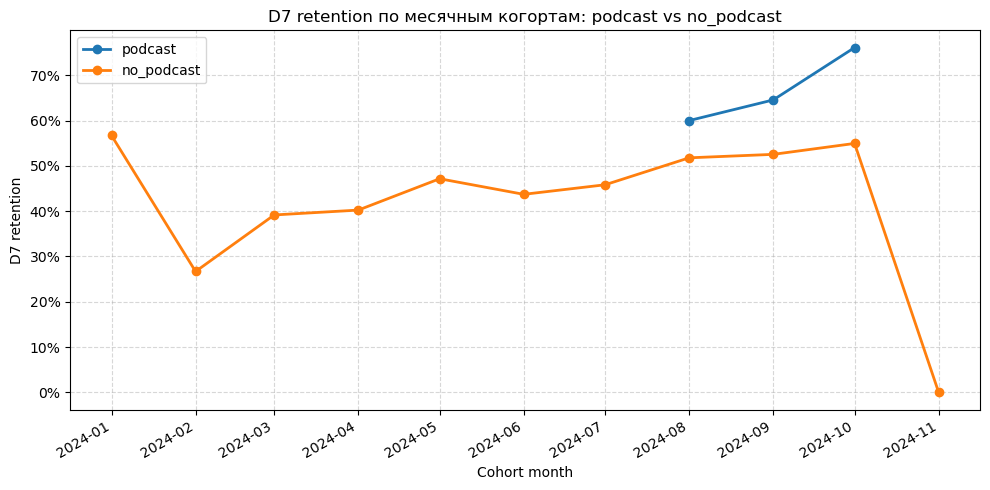

In [156]:
# 1) Размеры когорт по сегментам
cohort_sizes = (
    user_map.groupby(['cohort_month','segment'], observed=True)['uid']
            .nunique()
            .rename('cohort_size')
            .reset_index()
)

# 2) Retention: склейка и расчёт
retention = cohort_sizes.merge(active_d7, on=['cohort_month','segment'], how='left')
retention['active_d7'] = retention['active_d7'].fillna(0)

# избегаем деления на 0: если cohort_size == 0 → NaN
retention['D7_retention'] = np.where(
    retention['cohort_size'].gt(0),
    retention['active_d7'] / retention['cohort_size'],
    np.nan
)

# 3) Пивот с ДВУМЯ колонками (гарантируем порядок)
retention_pivot_seg = (
    retention.pivot(index='cohort_month', columns='segment', values='D7_retention')
             .reindex(columns=['podcast','no_podcast'])    # оба столбца в выходе
             .sort_index()
             .reset_index()
)

print(retention_pivot_seg.head())

# 4) График: две линии на одной оси
fig, ax = plt.subplots(figsize=(10, 5))
if 'podcast' in retention_pivot_seg.columns:
    ax.plot(retention_pivot_seg['cohort_month'], retention_pivot_seg['podcast'],
            marker='o', linewidth=2, label='podcast')
if 'no_podcast' in retention_pivot_seg.columns:
    ax.plot(retention_pivot_seg['cohort_month'], retention_pivot_seg['no_podcast'],
            marker='o', linewidth=2, label='no_podcast')

ax.set_title('D7 retention по месячным когортам: podcast vs no_podcast')
ax.set_xlabel('Cohort month')
ax.set_ylabel('D7 retention')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


как будто ретеншен тех, кто слушал подкасты более обнадеживающий и тренд наметился на рост

#### 6. Приоритизация метрик  — 2 балла

Составьте список всех метрик, которые были рассчитаны выше (не забудьте, что показатель, рассчитанный в разрезе сегмента — это отдельная метрика). Для простоты давайте ориентироваться только на недельную агрегацию.

1. Присвойте метрикам приоритеты P0-P3 по принципу (в этом пункте стройте приоритизацию на уровне всей компании):
   -  P0 — бизнес результат;
   -  P1 — метрики продукта, напрямую аффектящие бизнес-результат (retention, product as a habit);
   -  P2 — метрики, отражающие взаимодействие пользователя с продуктом (user experience, user engagement) / таргет-метрики отдельных команд продукта;
   -  P3 — метрики стримов / опыт пользователя в рамках работы отдельных команд.
2. Пересоберите приоритеты только для команды подкастов, если цель развития подкастов — рост пользователей с подпиской. Обратите внимание, что вам не нужно отказываться от метрик, рассчитанных по всем пользователям (без сегментов) или для сегмента Music (полезно понимать, не каннибализируем ли мы основной тип контента). Скорее всего приоритеты изменятся только для посегментных метрик.
4. Представьте, что цель внедрения подкастов поменялась — теперь команда в первую очередь хочет задрайвить вовлеченность в продукт. Пересоберите приоритеты при необходимости (в данном пункте могут измениться приоритеты для метрик, рассчитанных по всем пользователям).

Для каждого из пунктов дайте краткое обоснование, почему вы присвоили приоритеты именно так.

# your answer is here
P0 — бизнес-результат

Weekly premium share → P0. Прямо отражает долю платящих пользователей и выручку/ARPU на уровне компании.

P1 — продуктовые метрики, напрямую влияющие на бизнес (habit/retention)

D7 retention (overall) → P1. Короткий горизонт удержания — сильный драйвер платёжного конверсинга и LTV.

D30 retention (overall) → P1. Долгий горизонт удержания — устойчивость базы и продление подписок.

WAU → P1. Ширина воронки: чем выше база активов, тем больше платящих при равной конверсии.

stickiness → P1. Привычность использования коррелирует с удержанием и подпиской.

P2 — UX/engagement и таргет-метрики отдельных команд

D7 retention — podcast (с подкастом) → P2. Показывает вклад подкаст-опыта в раннее удержание.

D30 retention — podcast (с подкастом) → P2. Вклад подкаст-опыта в длительное удержание.

D7/D30 — podcast (без подкаста) → P2. Контрольная группа для оценки относительного эффекта подкастов.

P3 — стримовые/операционные внутри отдельных команд

Любые дополнительные разрезы этих показателей по операционным подстримам (жанры, плейлисты, типы подкастов, технические вариации) → P3. Полезно для внутренних улучшений, но не для company-level OKR.

компания живёт за счёт выручки → premium share = P0. Следом — метрики привычности/удержания и масштаба базы (P1). Посегментные «подкаст/не подкаст» важны, но это уже вклад конкретного стрима (P2–P3).
